# TFG Alberto Pampín

En esta hoja se hará un análisis de los datos
provenientes de las mediciones de los sensores proporcionadas por el
ayuntamiento de la ciudad de Santiago de Compostela.

## Descripción del dataset

En primer lugar hay que hacer los imports necesarios:

In [24]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from math import ceil
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

Se realiza la carga del fichero .csv que contiene los datos:

In [25]:
#csv_path = "../data/2_Oct2019.csv"
csv_path = "../data/historico_10_19_02_20.csv"
df = pd.read_csv(csv_path)


En este fichero se encuentran las mediciones que han realizado los sensores instalados en la ciudad de Santiago
de Compostela desde Octubre-2019 hasta Febrero-2020 (ambos incluidos).

**NOTA**: Al tratarse de un problema real las mediciones realizadas a partir de Marzo-2020 se han visto afectadas por
las restricciones sanitarias a causa del COVID-19, es por eso que no se tomarán en cuenta las mediciones a partir
de dicha fecha.

Ahora veamos cómo son los datos:

In [26]:
df.head()

,_id,speed,sensor,flow,FID,datetime
0,1,-9999,PM084,12,historic_traffic_observations_2019_10.fid-76a8...,2019-10-01T00:00:00
1,2,-9999,PM036,12,historic_traffic_observations_2019_10.fid-76a8...,2019-10-01T00:00:00
2,3,-9999,PM037,0,historic_traffic_observations_2019_10.fid-76a8...,2019-10-01T00:00:00
3,4,-9999,PM083,12,historic_traffic_observations_2019_10.fid-76a8...,2019-10-01T00:00:00
4,5,-9999,PM082,12,historic_traffic_observations_2019_10.fid-76a8...,2019-10-01T00:00:00


Las columnas del dataset son las siguientes:
* `_id` (Integer): Identificador de la medición dentro del mes
* `speed` (Integer): NA
* `sensor` (String): Nombre del sensor que realizó la medición
* `flow` (Integer): Su valor entre 12 muestra el número de vehículos que pasaron sobre el sensor en los últimos 5 minutos
* `FID` (String): Identificador de la medición global -> PRIMARY KEY
* `datetime` (Timestamp): Fecha y hora en la que se tomó la medición.
Cada sensor inserta una nueva medición cada 5 minutos

In [27]:
df.shape

(2904410, 6)

Hay un total de **2904410 mediciones** y **6 columnas**.

Algunos datos interesantes sobre el dataset:

In [28]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
_id,2904410.0,292897.638104,171773.694631,1.0,145221.0,290441.5,435662.0,638663.0
speed,2904410.0,-9999.000000,0.000000,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0
flow,2904410.0,148.064983,391.402798,0.0,0.0,48.0,228.0,99999.0


El max de `flow` y por ende el de `car_count` no parece un número muy normal, y menos
tratándose de una ciudad como Santiago de Compostela, dónde es imposible que circulen 8333
vehículos sobre un sensor en 5 minutos:

<AxesSubplot:>

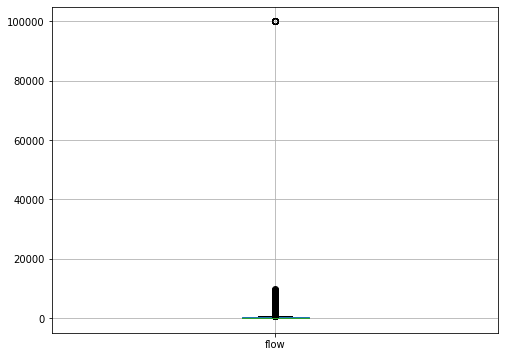

In [29]:
df.boxplot(column=['flow'])

In [30]:
bad_flow = df.loc[df['flow'] == 99999]
len(bad_flow)

31

Hay 31 mediciones con un valor erróneo para la columna `flow`: **Es necesario arreglar estos valores extremos!**

## Procesamiento del dataset

Algunos de los datos del dataset no interesan, bien porque su valor no es válido (`speed`) o bien porque
son simples identificadores (`_id` y `FID`). También se deberán formatear otras columnas:

In [31]:
df.pop('speed')
df.pop('FID')
df.pop('_id')

df.loc[:,'datetime'] = pd.to_datetime(df.loc[:,'datetime'], format='%Y-%m-%dT%H:%M:%S')

df['car_count'] = df.loc[:, 'flow'].div(12)

In [32]:
df.head()

,sensor,flow,datetime,car_count
0,PM084,12,2019-10-01,1.0
1,PM036,12,2019-10-01,1.0
2,PM037,0,2019-10-01,0.0
3,PM083,12,2019-10-01,1.0
4,PM082,12,2019-10-01,1.0


Acciones realizadas:
1. La columna `speed` no aporta nada, todos su valores son -9999
2. La columna `FID` tampoco, es un identificador de cada medición, al igual que `_id`
3. La columna `datetime` tuvo que ser formateada para obtener un formato válido
4. La columna `flow` es útil, pero es más interesante conocer el número de vehículos que
 pasaron sobre el sensor en los últimos 5 minutos: `car_count`

Seleccionemos 5 mediciones al azar:

In [33]:
df.sample(n=5, random_state=12)

,sensor,flow,datetime,car_count
1649509,PM034,0,2019-12-26 10:40:00,0.0
1399977,PM074,0,2019-12-13 23:50:00,0.0
367417,PM030,360,2019-10-19 17:45:00,30.0
413522,PM058,36,2019-10-21 22:20:00,3.0
983227,PM059,0,2019-11-27 04:45:00,0.0


Veamos algunas estadísticas del conjunto de datos:

In [34]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
flow,2904410.0,148.064983,391.402798,0.0,0.0,48.0,228.0,99999.00
car_count,2904410.0,12.338749,32.616900,0.0,0.0,4.0,19.0,8333.25


Como ya se comentó en la sección anterior, existen 31 outlayers claros ( valor 99999.0 en la columna `flow`) que deben
ser eliminados:

In [35]:
df = df[df.flow != 99999.0]
df = df[df.car_count != 8333.25]

Podemos ver que ya no hay ninguna fila con `flow == 99999.0`:

In [36]:
bad_flow = df.loc[df['flow'] == 99999.0]
len(bad_flow)

0

Revisando de nuevo las estadísticas del dataset:

In [37]:
df.describe().transpose()


,count,mean,std,min,25%,50%,75%,max
flow,2904379.0,146.999220,216.285009,0.0,0.0,48.0,228.0,9672.0
car_count,2904379.0,12.249935,18.023751,0.0,0.0,4.0,19.0,806.0


<AxesSubplot:>

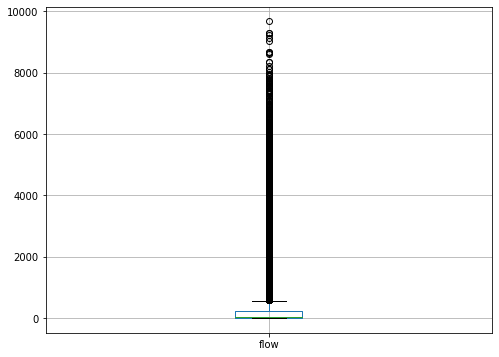

In [38]:
df.boxplot(column=['flow'])

Parece que ahora tiene algo más de sentido.

## Experimentos

Los experimentos a realizar consisten en predecir el tráfico en el punto en el que se ubica el
sensor `PM072` (CITIUS) en un instante `t` a partir de las mediciones realizadas por otros
sensores en un instante `t-x`. Los experimentos contemplados son los siguientes:

1. Predecir en `PM072` a partir de:
    - `PM029` (Entrada túnel Romero Donallo)
    - `PM034`(Rotonda Camiño Novo - Avda. Mestre Mateo)

2. Predecir en `PM072` a partir de:
    - `PM024` (Rotonda Camiño Novo - Avda. Romero Donallo)
    - `PM030` (Avda. Rosalía de Castro - Rotonda Camiño Novo)
    - `PM031` (Avda. Romero Donallo - Rotonda Camiño Novo)
    - `PM032` (Avda. Rosalía de Castro - Rotonda Camiño Novo)
    - `PM033` (Avda. Mestre Mateo - Rotonda Camiño Novo)
    - `PM034` (Rotonda Camiño Novo - Avda. Mestre Mateo)

3. Predecir en `PM072` a partir de (Idem 2, pero sin `PM034`):
    - `PM024` (Rotonda Camiño Novo - Avda. Romero Donallo)
    - `PM030` (Avda. Rosalía de Castro - Rotonda Camiño Novo)
    - `PM031` (Avda. Romero Donallo - Rotonda Camiño Novo)
    - `PM032` (Avda. Rosalía de Castro - Rotonda Camiño Novo)
    - `PM033` (Avda. Mestre Mateo - Rotonda Camiño Novo)

4. Predecir en `PM072` a partir de:
    - Todos los sensores disponibles

5. Predecir en `PM072` a partir de:
    - `PM020` (Rotonda Galuresa - Avda. Romero Donallo)
    - `PM076` (Rúa do Horreo - Rotonda Galuresa)
    - `PM077` (Avda. Romero Donallo - Rotonda Galuresa)
    - `PM079` (Rúa do Horreo - Rotonda Galuresa)

Para cada uno de los experimentos anteriormente citados se llevará a cabo la implementación del modelo con:
* Perceptrón multicapa
* Red Neuronal Convolucional (CNN)
* Red Neuronal Recurrente (RNN)

Asimismo, se deberá realizar un análisis de la varianza y bias para cada experimento
(Ver 6 primeras semanas Machine Learning Stanford: https://www.coursera.org/learn/machine-learning)

Por otra parte, también se probarán diversas formas de incluir las marcas temporales (timestamps) en el modelo:
* Día de la semana (1-7) y hora del día (minutos)
* Día de la semana y hora del día *modelado con sin y cos*
* Ventanas temporales (¿?)

## Experimento #1

Tal y como se indicó en el apartado `Experimentos`, en el **Experimento #1** se tratará de predecir
el tráfico en el punto en el que se ubica el sensor `PM072` (CITIUS) en un instante t a partir de
las mediciones realizadas en un instante `t-x` por los sensores:
* `PM029` (Entrada túnel Romero Donallo)
* `PM034`(Rotonda Camiño Novo - Avda. Mestre Mateo)


### Análisis dataset Experimento #1

En primer lugar, hay que obtener solo aquellas mediciones que hayan sido tomadas por los sensores que resultan
de interés para el experimento:

In [39]:
sensors_list = ['PM029', 'PM034', 'PM072']
df_1 = df.loc[df['sensor'].isin(sensors_list)]

Al igual que antes, veamos algunos estadísticas sobre este conjunto:

In [40]:
df_1.sample(n=5)

,sensor,flow,datetime,car_count
675689,PM072,240,2019-11-12 11:45:00,20.0
132200,PM072,252,2019-10-07 07:25:00,21.0
1343037,PM029,120,2019-12-11 06:15:00,10.0
247279,PM034,0,2019-10-12 18:50:00,0.0
1944957,PM034,0,2020-01-17 12:10:00,0.0


In [42]:
df_1.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
flow,118555.0,133.790966,173.702378,0.0,0.0,48.0,228.0,1104.0
car_count,118555.0,11.149247,14.475198,0.0,0.0,4.0,19.0,92.0


Veamos un boxplot:

<AxesSubplot:>

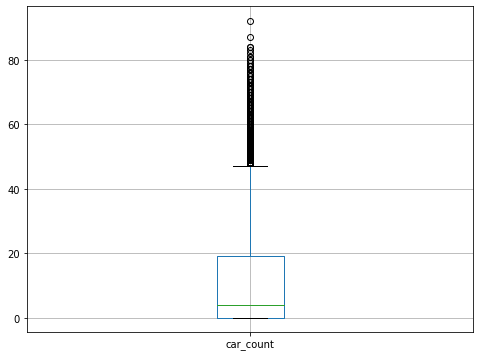

In [41]:
df_1.boxplot(column=['car_count'])

No parece haber un outlayer muy claro como en el apartado `Descripción del dataset`

### Análisis gráfico Experimento #1

Para ver la evolución de los datos del tráfico de manera más intuitiva se realizarán una serie de representaciones
gráficas.

La siguiente función recibe un dataframe, una lista de días y el nombre de un sensor. Grafica todas las mediciones
realizadas por ese sensor (agregados de 5 minutos) a lo largo de los días indicados

In [67]:
def plot_sensors_daily_data(df_orig, days_list, sensor):

    # Solo selecciono la información de ese sensor en el rango indicado
    df = df_orig.loc[(df_orig['sensor'] == sensor)
                     & (df_orig['datetime'] >= days_list[0])
                     & (df_orig['datetime'] <= days_list[-1]+datetime.timedelta(days=1))]

    fig, axs = plt.subplots(days_list.shape[0], figsize=(15,15))
    fig.tight_layout(pad=5.0)
    fig.suptitle('Data Sensor ' + sensor, fontsize=16)

    for i in range(days_list.shape[0]):
        x = df.loc[(df['datetime'] >= days_list[i]) & (df['datetime'] <= days_list[i]+datetime.timedelta(days=1)), 'datetime']
        y = df.loc[(df['datetime'] >= days_list[i]) & (df['datetime'] <= days_list[i]+datetime.timedelta(days=1)), 'car_count']

        myFmt = mdates.DateFormatter('%H:%M')
        axs[i].xaxis.set_major_formatter(myFmt)
        axs[i].set(xlabel='Hours', ylabel='Car count')
        axs[i].set_title('Day: '+ days_list[i].strftime("%Y-%m-%d (%A)"))

        axs[i].plot(x, y)

Podemos probar a pasarle los 7 días de una semana para ver como evoluciona el tráfico que pasa
por ese sensor durante esa semana:

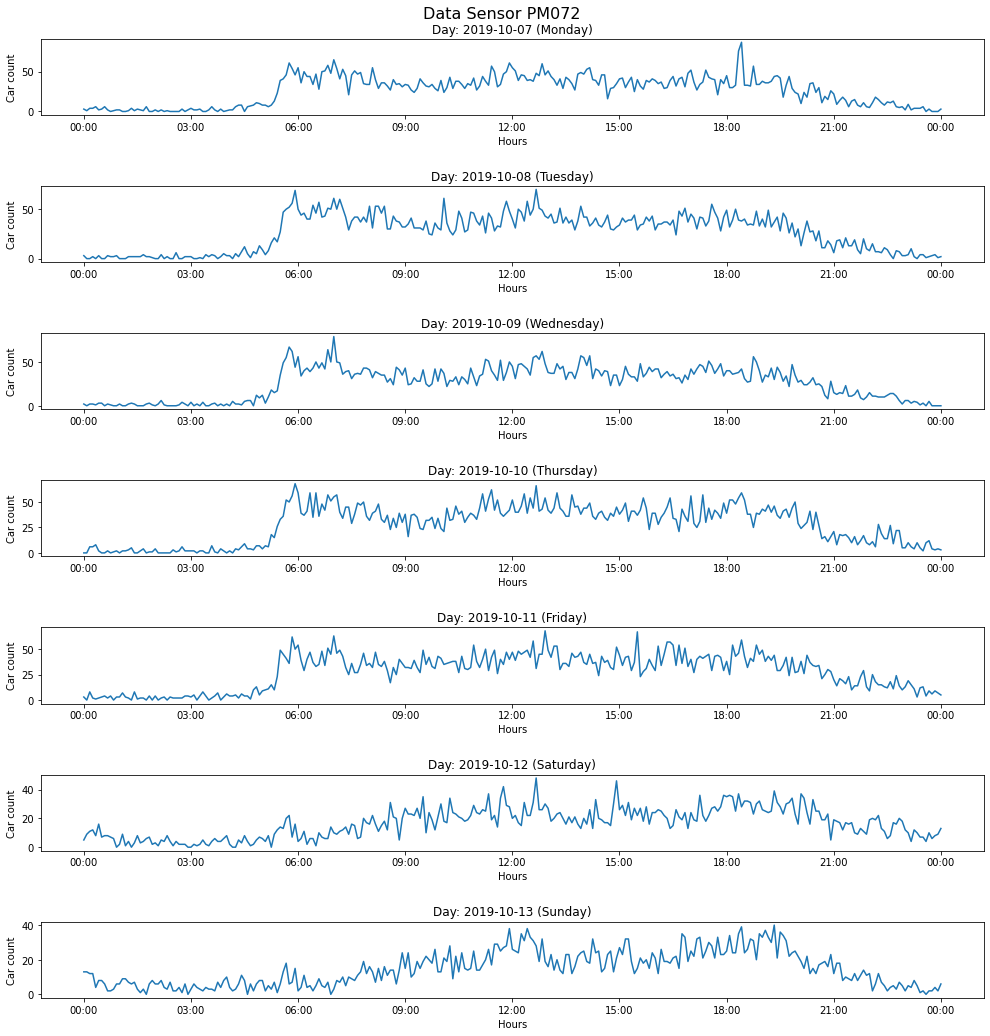

In [68]:
days = pd.date_range(start='2019-10-07', end='2019-10-13', freq='D')
plot_sensors_daily_data(df_orig=df_1, days_list = days, sensor='PM072')

También podemos graficar los lunes (o cualquier día de la semana: W-SUN, W-FRI) que hubo en un mes:

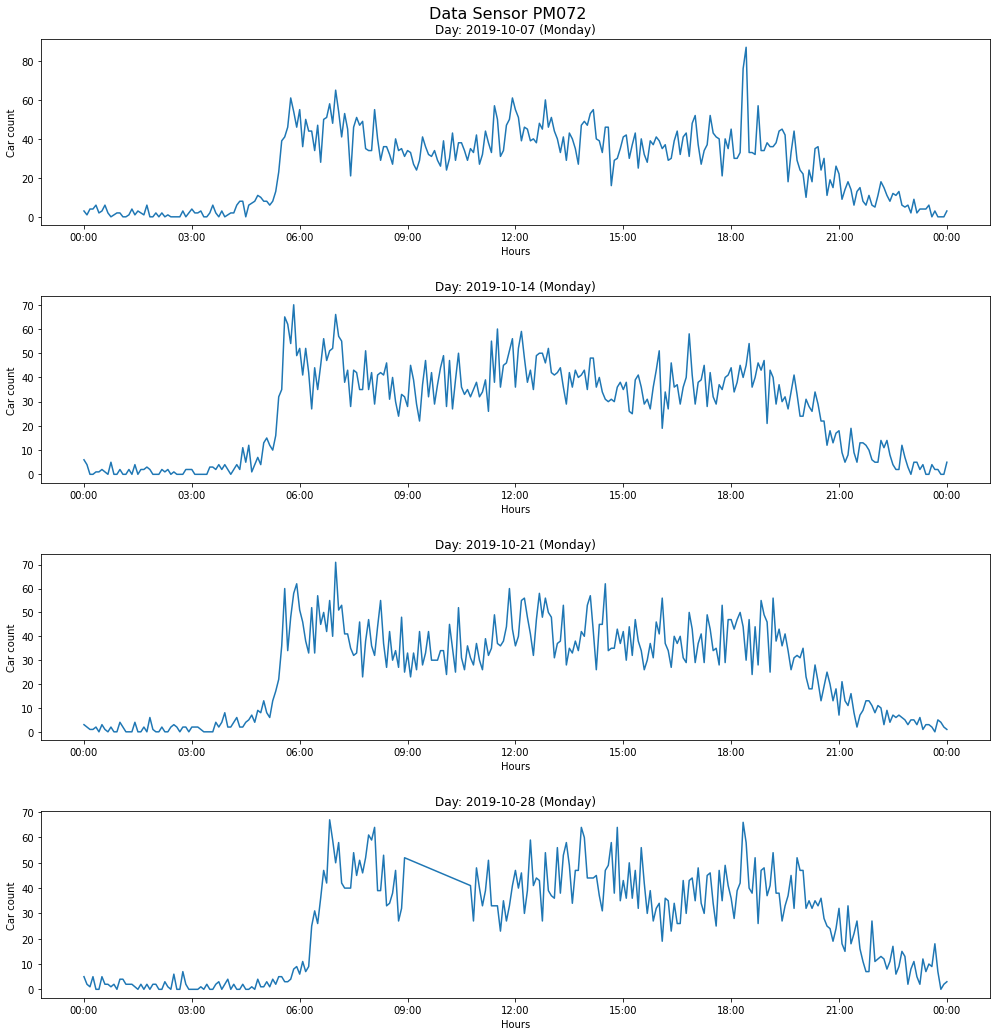

In [64]:
days = pd.date_range(start='2019-10-01', end='2019-10-31', freq='W-MON')
plot_sensors_daily_data(df_orig=df_1, days_list = days, sensor='PM072')

Las gráficas anteriores tienen mucho ruido, aunque resultan útiles para hacer una comprobación de outlayers.
Sin embargo, para ver de una manera más directa si existe periodicidad en el tráfico es más interesante **representar
los datos con agregados superiores a 5 minutos**

La siguiente función recibe un dataframe, una lista de días, un valor `n` que indica el número de mediciones agregadas,
y el nombre de un sensor. Grafica la media (mean) y desviación típica (std) de las mediciones realizadas durante el sensor
durante esos días en **agregados de 5*n minutos**

In [82]:
def plot_sensors_agregated_daily_data(df_orig, days_list, n, sensor):

    # Solo selecciono la información de ese sensor en el rango indicado
    df = df_orig.loc[(df_orig['sensor'] == sensor)
                     & (df_orig['datetime'] >= days_list[0])
                     & (df_orig['datetime'] <= days_list[-1]+datetime.timedelta(days=1))]

    # Dataframe con los agregados
    df_mean = pd.DataFrame(columns=df.columns)
    df_std = pd.DataFrame(columns=df.columns)

    for g, df_slice in df.groupby(np.arange(len(df)) // n):
        mean_row = {'sensor': sensor, 'flow': df_slice['flow'].mean(), 'datetime': df_slice['datetime'].max(), 'car_count': df_slice['car_count'].mean()}
        df_mean = df_mean.append(mean_row, ignore_index=True)

        std_row = {'sensor': sensor, 'flow': df_slice['flow'].std(), 'datetime': df_slice['datetime'].max(), 'car_count': df_slice['car_count'].std()}
        df_std = df_std.append(std_row, ignore_index=True)

    fig, axs = plt.subplots(days_list.shape[0], figsize=(15,15))
    fig.tight_layout(pad=5.0)
    fig.suptitle('Data Sensor ' + sensor, fontsize=16)

    for i in range(days_list.shape[0]):
        x = df_mean.loc[(df_mean['datetime'] >= days_list[i]) & (df_mean['datetime'] <= days_list[i]+datetime.timedelta(days=1)), 'datetime']
        y_mean = df_mean.loc[(df_mean['datetime'] >= days_list[i]) & (df_mean['datetime'] <= days_list[i]+datetime.timedelta(days=1)), 'car_count']
        y_std = df_std.loc[(df_std['datetime'] >= days_list[i]) & (df_std['datetime'] <= days_list[i]+datetime.timedelta(days=1)), 'car_count']

        myFmt = mdates.DateFormatter('%H:%M')
        axs[i].xaxis.set_major_formatter(myFmt)
        axs[i].set(xlabel='Hours', ylabel='Car count')
        axs[i].set_title('Day: '+ days_list[i].strftime("%Y-%m-%d (%A)"))

        axs[i].plot(x, y_mean, label='mean')
        axs[i].plot(x, y_std, label='std')
        axs[i].legend(loc="upper left")

Veamos la evolución del tráfico (media y desviación típica) durante una semana con agregados de 30 minutos (5*6)

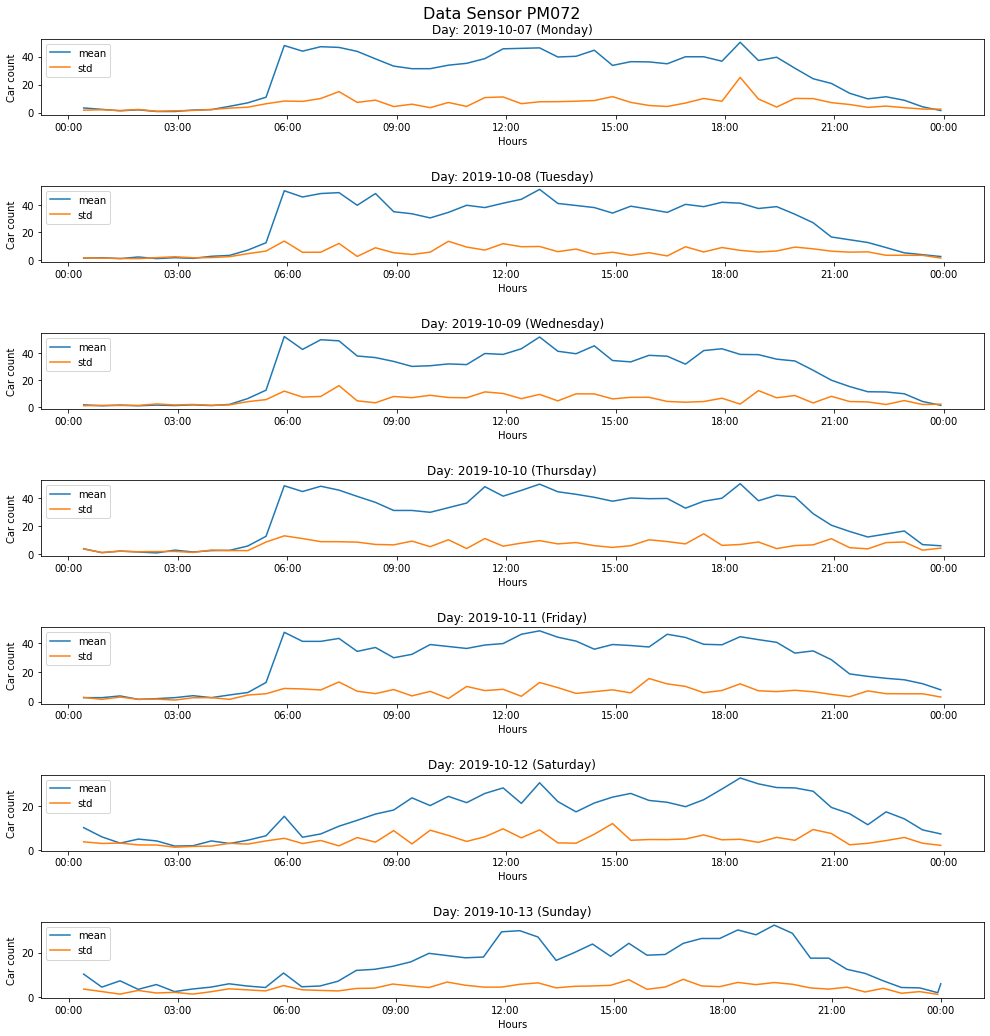

In [83]:
days = pd.date_range(start='2019-10-07', end='2019-10-13', freq='D')
plot_sensors_agregated_daily_data(df_orig=df_1, days_list = days, n=6, sensor='PM072')

Veamos la evolución del tráfico durante los lunes de un mes con agregados de 30 minutos (5*6)

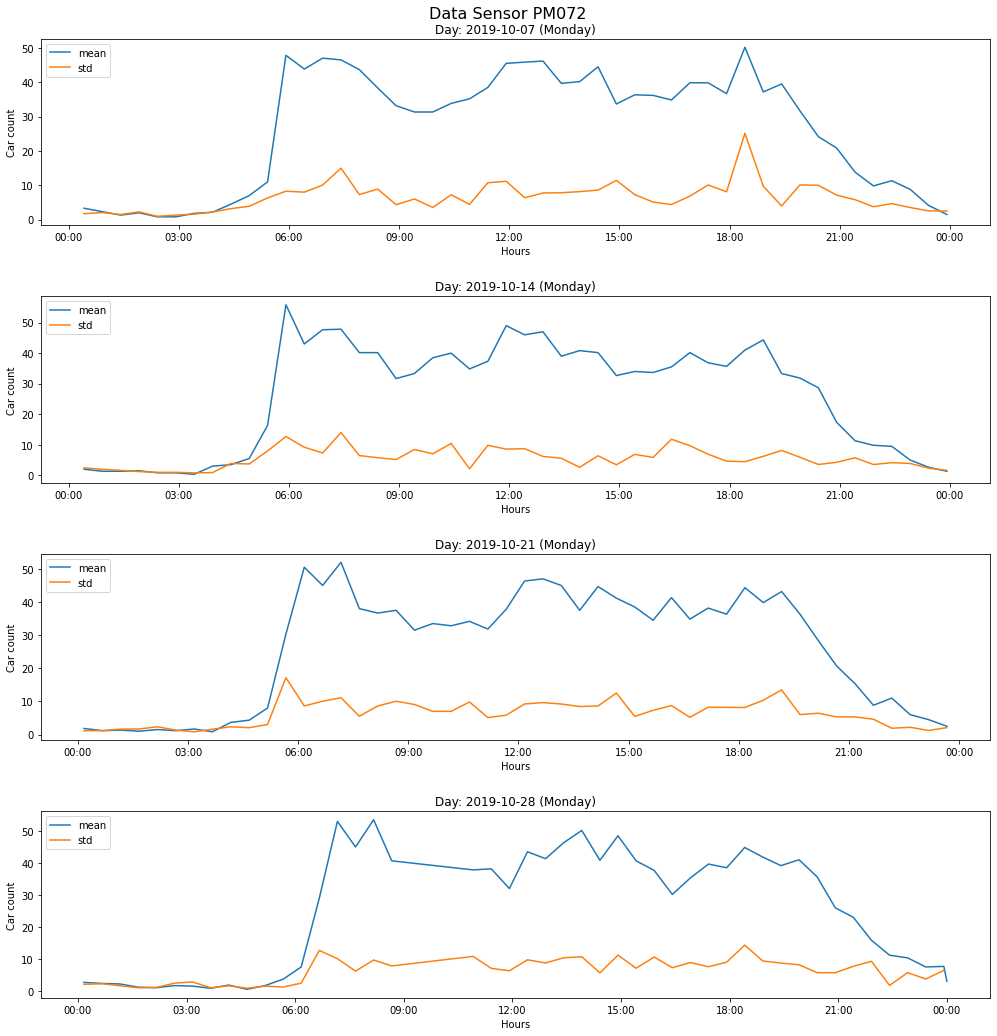

In [89]:
days = pd.date_range(start='2019-10-01', end='2019-10-31', freq='W-MON')
plot_sensors_agregated_daily_data(df_orig=df_1, days_list = days, n=6, sensor='PM072')


# HASTA AQUÍ HE LLEGAOD HOY (10/03/21)

Veamos la evolución de las mediciones del sensor `PM016` durante la semana donde se alcanza el máximo `car_count`:

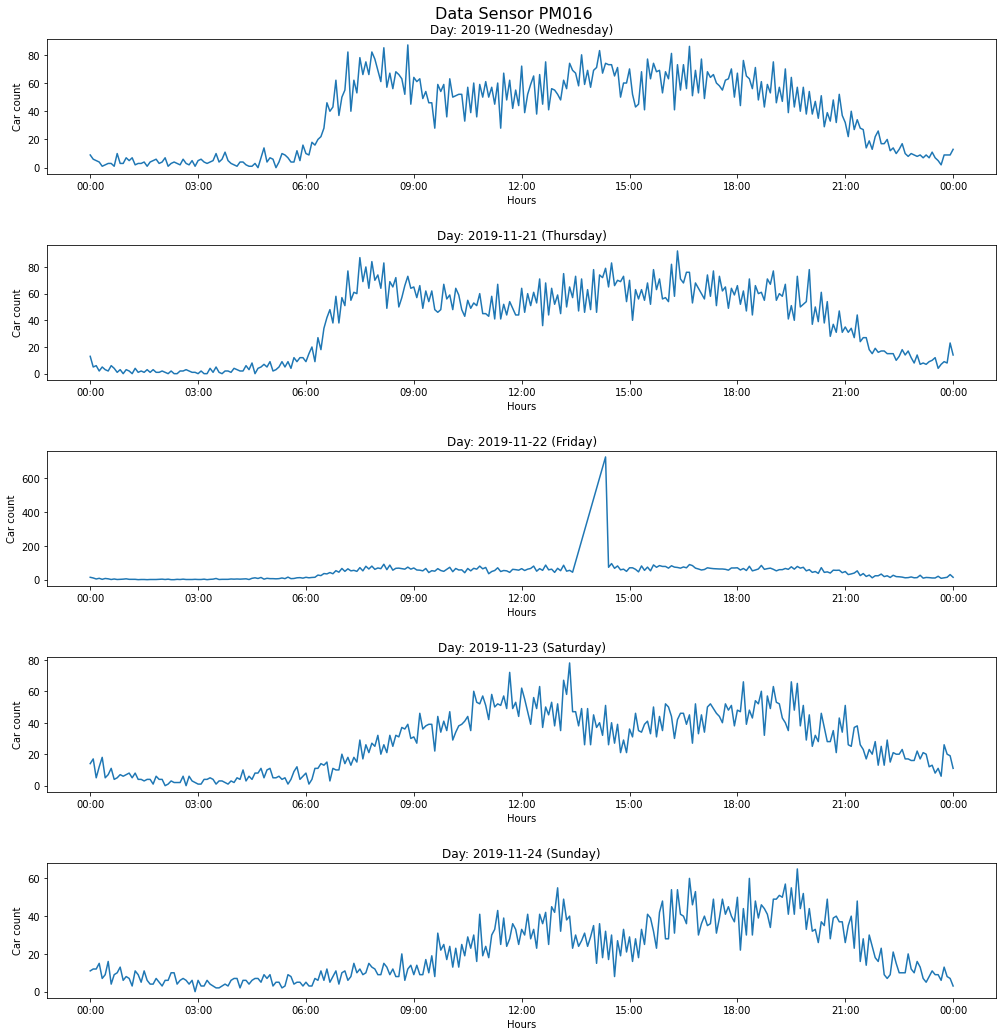

In [25]:
days = pd.date_range(start='2019-11-20', end='2019-11-24', freq='D')
plot_sensors_daily_data(sensor='PM016', daylist = days, df_orig=df)

Parece bastante claro que este valor se debe a un error. Veamos como se comportan los viernes de ese mes:

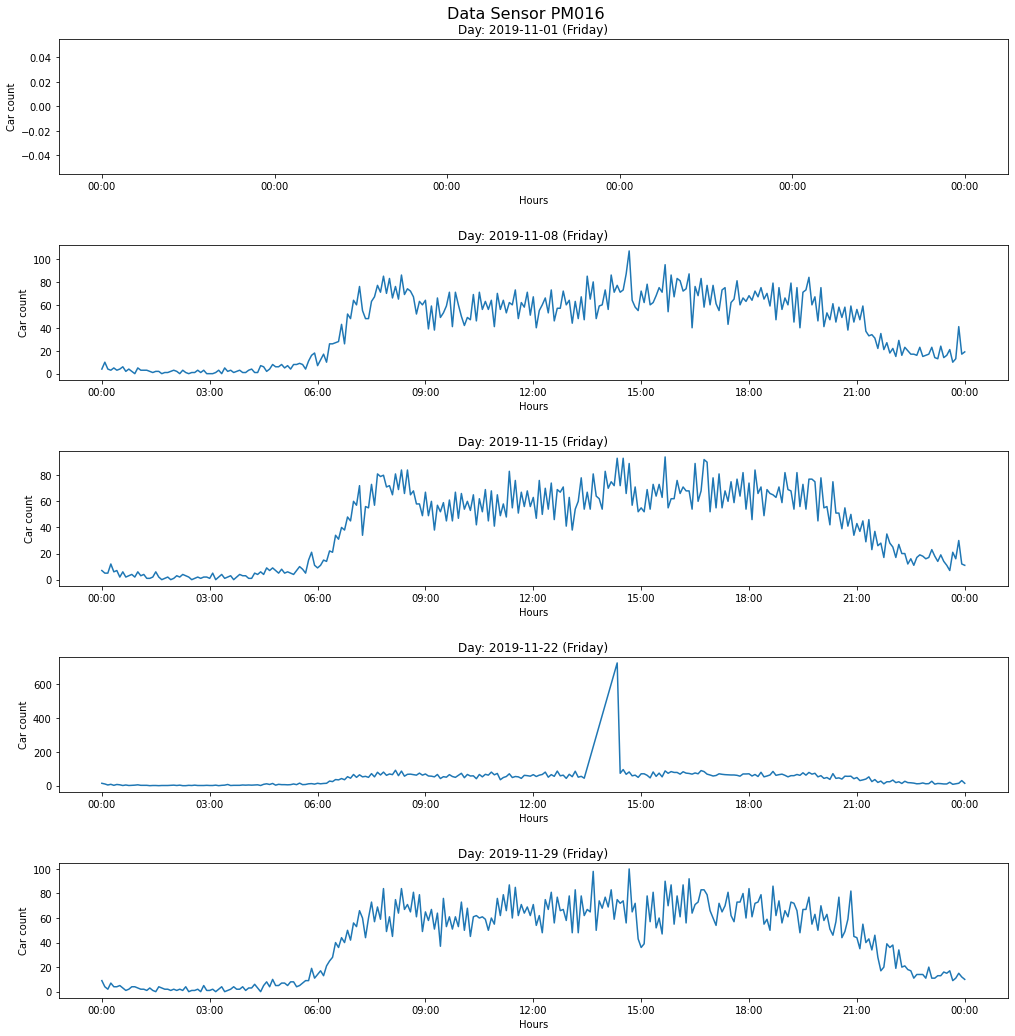

In [26]:
days = pd.date_range(start='2019-11-01', end='2019-11-30', freq='W-FRI')
plot_sensors_daily_data(sensor='PM016', daylist = days, df_orig=df)

**Definitivamente se trata de un outlayer!**

## Tratamiento de outlayers

In [27]:
adf

fad
flowad
fa
df

adf
adf

af

NameError: name 'adf' is not defined

## Feature engineering

Antes de construir un modelo es importante entender los datos con los que se trabaja y estar seguro que los datos
que se le pasan al modelo está correctamente formateados.

#### Horas del día
La columna `datetime` resulta de gran importancia, pero no como una cadena. El primer paso es pasarla
a segundos:

In [28]:
date_time = df.loc[:, 'datetime']
timestamp_s = date_time.map(datetime.datetime.timestamp)

El tiempo en segundos no resulta muy útil como input para el modelo. Está claro que la periodicidad del tráfico es diaria.

**Más adelante tengo que discutir si es semanal, ya que si no cojo el finde...**

Para convertir el tiempo en una señal usable se puede usar el seno y el coseno:

In [29]:
seconds_in_day = 24*60*60
df['hour_sin'] = np.sin(timestamp_s * (2 * np.pi / seconds_in_day))
df['hour_cos'] = np.cos(timestamp_s * (2 * np.pi / seconds_in_day))

De esta manera logramos modelar las horas como en un reloj, las 00h y están a continuación de las 23h.

La gráfica correspondiente al primer día del dataset en el sensor `PM072` es el siguiente
([:288] porque cada hora hay 12 mediciones * 24h = 288):

**Comentario personal:** Es necesario indicar un sensor en concreto, ya que todos toman una medición cada 5 minutos, por
lo que de no hacerlo no se vería nada en la gráfica!

Text(0.5, 1.0, 'Time of day signal')

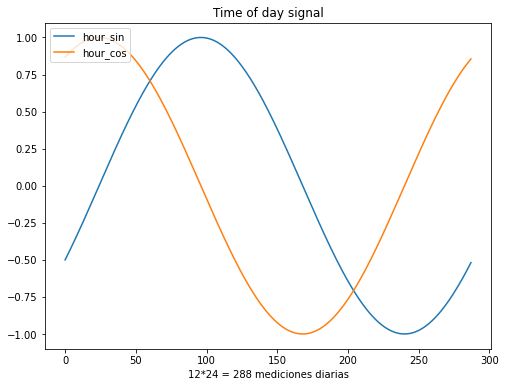

In [30]:
plt.plot(np.array(df.loc[df['sensor'] == 'PM072', 'hour_sin'][:288]), label = 'hour_sin')
plt.plot(np.array(df.loc[df['sensor'] == 'PM072', 'hour_cos'][:288]), label = 'hour_cos')
plt.legend(loc="upper left")
plt.xlabel('12*24 = 288 mediciones diarias')
plt.title('Time of day signal')

Si solamente nos fijamos en el seno, al trazar una línea horizontal se cruza en dos puntos, por lo que sólo teniendo
en cuenta esta característica, las 00:00h y las 12:00h son lo mismo. Para solucionar esto tenemos el coseno, con ambas
características ya podemos distinguir esas horas y todo codificado de manera cíclica!

Una forma más intuitiva de ver lo que acabamos de hacer es representar ambas características como si se tratase un reloj:

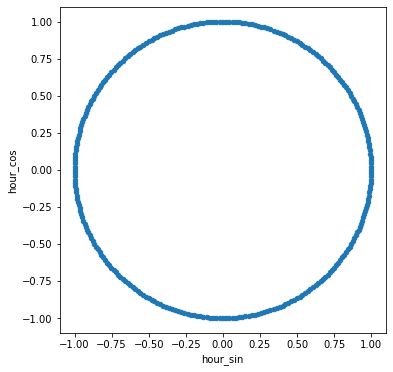

In [31]:
df.loc[df['sensor'] == 'PM072'][:288].plot.scatter('hour_sin','hour_cos').set_aspect('equal');

**Comentario personal:** Fíjate en las tablas a continuación que, evidentemente,
hour_sin` y  `hour_cos` son iguales para 2019-10-01 00:00:00 y 2019-10-02 00:00:00.
Como nos interesa que también se tenga en cuenta el día de la semana tenemos que hacer algo más!!

In [32]:
df.loc[df['sensor'] == 'PM072'][:2]


,sensor,flow,datetime,car_count,hour_sin,hour_cos
21,PM072,48,2019-10-01 00:00:00,4.0,-0.500000,0.866025
94,PM072,0,2019-10-01 00:05:00,0.0,-0.480989,0.876727


In [33]:
df.loc[df['sensor'] == 'PM072'][288:290]

,sensor,flow,datetime,car_count,hour_sin,hour_cos
21045,PM072,24,2019-10-02 00:00:00,2.0,-0.500000,0.866025
21118,PM072,24,2019-10-02 00:05:00,2.0,-0.480989,0.876727


#### Días de la semana

Tal y como hemos visto en las gráficas durante el `Análisis gráfico`, el tráfico tiene una clara frecuencia semanal.
Se puede ver cómo las gráficas de cada uno de los lunes (por ejemplo) son muy similares. Esto es algo que nos interesa
que nuestro modelo conozca, por lo que tenemos que realizar un trabajo similar al que hemos realizado con las horas.
*Los días de la semana también son cíclicos!*

In [34]:
df['week_day'] = df['datetime'].dt.weekday
days_in_week = 7 # dt.weekday asigna valores del 0 (Lunes) al 6 (Domingo)
df['wday_sin'] = np.sin(df['week_day'] * (2 * np.pi / days_in_week))
df['wday_cos'] = np.cos(df['week_day'] * (2 * np.pi / days_in_week))

Nuevamente, en una representación circular, vemos los 7 días de la semana:

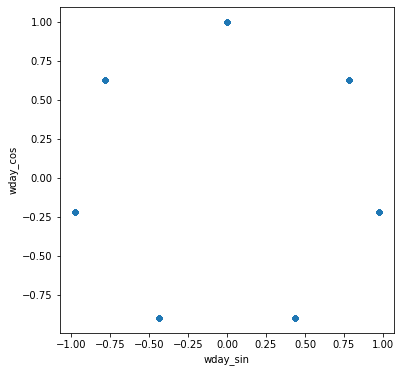

In [35]:
df.loc[df['sensor'] == 'PM072'][:2100].plot.scatter('wday_sin','wday_cos').set_aspect('equal');

**Comentario personal:** Cada uno de los 7 puntos que vemos contiene 288 puntos (hay 288 mediciones cada día).
En la siguiente tabla podemos ver como cada día de la semana (del 0 al 6) tiene un `wday_sin` y `wday_cos` diferente!!

In [36]:
df.loc[df['sensor'] == 'PM072'][0:2000:288]

,sensor,flow,datetime,car_count,hour_sin,hour_cos,week_day,wday_sin,wday_cos
21,PM072,48,2019-10-01 00:00:00,4.0,-0.500000,0.866025,1,0.781831,0.623490
21045,PM072,24,2019-10-02 00:00:00,2.0,-0.500000,0.866025,2,0.974928,-0.222521
41943,PM072,24,2019-10-03 00:00:00,2.0,-0.500000,0.866025,3,0.433884,-0.900969
74749,PM072,600,2019-10-04 13:50:00,50.0,0.043619,-0.999048,4,-0.433884,-0.900969
95773,PM072,264,2019-10-05 13:50:00,22.0,0.043619,-0.999048,5,-0.974928,-0.222521
116797,PM072,240,2019-10-06 13:50:00,20.0,0.043619,-0.999048,6,-0.781831,0.623490
137821,PM072,564,2019-10-07 13:50:00,47.0,0.043619,-0.999048,0,0.000000,1.000000


## División del dataset

Es necesario dividir el dataset en los cojuntos de:
* Entrenamiento: `98%`
* Validación: `1%`
* Test: `1%`

El dataset se divide de esta manera; es decir, sin hacer ningún shuffle por dos motivos:
1. Nos aseguramos coger ventanas de mediciones consecutivas
2. Los resultados de la validación y del test son más realistas, ya que se evalúan con datos recogidos
posteriormente a los usados para el entrenamiento

In [37]:
n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]


## Normalización de los datos
TODO: -------MIRAR FORMAS DE NORMALIZAR A PARTE DE LA DEL TUTORIAL!------

## Ventanas de datos